Troy Cope

March 6th, 2022 

Programming Assignment-03-CS4732-Troy Cope



In this section, we'll leverage the U-Net architecture to predict the class that corresponds to all the pixels in the image. A sample of such an input-output combination is as follows:

Note that, in the preceding picture, the objects that belong to the same class (in the left image – the input image) have the same pixel value (in the right image – the output image), which is why we are segmenting the pixels that are semantically similar to each other. This is also known as semantic segmentation.

 

Now, let's learn how to code semantic segmentation:

 

Let's begin by downloading the necessary datasets, installing the necessary packages, and then importing them. Once we've done that, we can define the device:

In [5]:
import os

import torch as torch

if not os.path.exists('dataset1'):
  
  !unzip /content/dataset1.zip

  !rm dataset1.zip

  !pip install jsonlines

  !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Archive:  /content/dataset1.zip
   creating: dataset1/
   creating: dataset1/annotations_prepped_test/
 extracting: dataset1/annotations_prepped_test/0016E5_08085.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08039.png  
 extracting: dataset1/annotations_prepped_test/0016E5_07995.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08067.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08073.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08123.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08159.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08157.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08047.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08075.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08121.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08053.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08119.png  
  inflating: dataset1/annotations_prepp

Define the function that will be used to transform images (tfms):

In [6]:
tfms = transforms.Compose([

transforms.ToTensor(),

transforms.Normalize([0.485, 0.456, 0.406],

[0.229, 0.224, 0.225])

])

Define the dataset class (SegData):
Specify the folder that contains images in the __init__ method:

In the __getitem__ method, we are resizing both the input (image) and output (mask) images so that they're the same shape. Note that the mask images contain integers that range between [0,11]. This indicates that there are 12 different classes.

In [1]:
class SegData(Dataset):
  def __init__(self, split):
    self.items=stems(f'dataset1/images_prepped_{split}')
    self.split = split

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):

    image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)

    image = cv2.resize(image, (224,224))

    mask=read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')

    mask = cv2.resize(mask, (224,224))

    return image, mask

  def choose(self): return self[randint(len(self))]

  def collate_fn(self, batch):
    ims, masks = list(zip(*batch))

    ims = torch.cat([tfms(im.copy()/255.) for im in ims]).float().to(device)

    ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)

    return ims, ce_masks

NameError: ignored

In the preceding code, we are preprocessing all the input images so that they have a channel (so that each image can be passed through a CNN later) once we've transformed the scaled images. Notice that ce_masks is a tensor of long integers, similar to the cross-entropy targets.

In [8]:
trn_ds = SegData('train')

val_ds = SegData('test')

trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)

val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [9]:
def conv(in_channels, out_channels):
  return nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))

In the preceding definition of conv, we are sequentially performing the Conv2d operation, the BatchNorm2d operation, and the ReLU operation

In [10]:
def up_conv(in_channels, out_channels):
  return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2), nn.ReLU(inplace=True))

ConvTranspose2d ensures that we upscale the images. This differs from the Conv2d operation, where we reduce the dimensions of the image. It takes an image that has in_channels number of channels as input channels and produces an image that has out_channels number of output channels.

In [11]:
from torchvision.models import vgg16_bn

class UNet(nn.Module):
  def __init__(self, pretrained=True, out_channels=12):

    super().__init__()

    self.encoder = \
                vgg16_bn(pretrained=pretrained).features

    self.block1 = nn.Sequential(*self.encoder[:6])

    self.block2 = nn.Sequential(*self.encoder[6:13])

    self.block3 = nn.Sequential(*self.encoder[13:20])

    self.block4 = nn.Sequential(*self.encoder[20:27])

    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])

    self.conv_bottleneck = conv(512, 1024)

    self.up_conv6 = up_conv(1024, 512)

    self.conv6 = conv(512 + 512, 512)

    self.up_conv7 = up_conv(512, 256)

    self.conv7 = conv(256 + 512, 256)

    self.up_conv8 = up_conv(256, 128)

    self.conv8 = conv(128 + 256, 128)

    self.up_conv9 = up_conv(128, 64)

    self.conv9 = conv(64 + 128, 64)

    self.up_conv10 = up_conv(64, 32)

    self.conv10 = conv(32 + 64, 32)

    self.conv11 = nn.Conv2d(32, out_channels, \

                            kernel_size=1)
  def forward(self, x):

    block1 = self.block1(x)

    block2 = self.block2(block1)

    block3 = self.block3(block2)

    block4 = self.block4(block3)

    block5 = self.block5(block4)

    bottleneck = self.bottleneck(block5)

    x = self.conv_bottleneck(bottleneck)

    x = self.up_conv6(x)

    x = torch.cat([x, block5], dim=1)

    x = self.conv6(x)

    x = self.up_conv7(x)

    x = torch.cat([x, block4], dim=1)

    x = self.conv7(x)

    x = self.up_conv8(x)

    x = torch.cat([x, block3], dim=1)

    x = self.conv8(x)

    x = self.up_conv9(x)

    x = torch.cat([x, block2], dim=1)

    x = self.conv9(x)

    x = self.up_conv10(x)

    x = torch.cat([x, block1], dim=1)

    x = self.conv10(x)

    x = self.conv11(x)

    return x

In the preceding code, we are making the U-style connection between the downscaling and upscaling convolution features by using torch.cat on the appropriate pairs of tensors.

In [12]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):

  ce_loss = ce(preds, targets)

  acc = (torch.max(preds, 1)[1] == targets).float().mean()

  return ce_loss, acc

In [13]:
def train_batch(model, data, optimizer, criterion):

  model.train()

  ims, ce_masks = data

  _masks = model(ims)

  optimizer.zero_grad()

  loss, acc = criterion(_masks, ce_masks)

  loss.backward()

  optimizer.step()

  return loss.item(), acc.item()

@torch.no_grad()

def validate_batch(model, data, criterion):

  model.eval()

  ims, masks = data

  _masks = model(ims)

  loss, acc = criterion(_masks, masks)

  return loss.item(), acc.item()

In [14]:
model = UNet().to(device)

criterion = UnetLoss

optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Current error is a conversion problem from [None] data type in the DataSet, but it gets cast. Therefore it should not be an issue this late in the program. "'NoneType' object is not subscriptable." This is due to the path not being correct on the data import.

In [15]:
log = Report(n_epochs)

for ex in range(n_epochs):
  N = len(trn_dl)
  for bx, data in enumerate(trn_dl):
    loss, acc = train_batch(model, data, optimizer, criterion)

  log.record(ex+(bx+1)/N,trn_loss=loss,trn_acc=acc, end='\r')

  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    log.record(ex+(bx+1)/N,val_loss=loss,val_acc=acc, end='\r')

  log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: nan	trn_acc: nan	val_loss: 0.775	val_acc: 0.812	(51.20s - 972.85s remaining)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


EPOCH: 2.000	trn_loss: 0.825	trn_acc: 0.805	val_loss: 1.115	val_acc: 0.680	(102.66s - 923.97s remaining)
EPOCH: 3.000	trn_loss: 0.551	trn_acc: 0.863	val_loss: 0.649	val_acc: 0.826	(154.05s - 872.93s remaining)
EPOCH: 4.000	trn_loss: 0.464	trn_acc: 0.881	val_loss: 0.688	val_acc: 0.820	(205.81s - 823.25s remaining)
EPOCH: 5.000	trn_loss: 0.473	trn_acc: 0.879	val_loss: 0.496	val_acc: 0.851	(257.18s - 771.54s remaining)
EPOCH: 6.000	trn_loss: 0.386	trn_acc: 0.894	val_loss: 0.445	val_acc: 0.876	(307.88s - 718.39s remaining)
EPOCH: 7.000	trn_loss: 0.310	trn_acc: 0.926	val_loss: 0.474	val_acc: 0.860	(358.19s - 665.22s remaining)
EPOCH: 8.000	trn_loss: 0.362	trn_acc: 0.902	val_loss: 0.388	val_acc: 0.876	(408.54s - 612.81s remaining)
EPOCH: 9.000	trn_loss: 0.646	trn_acc: 0.837	val_loss: 0.474	val_acc: 0.867	(458.74s - 560.68s remaining)
EPOCH: 10.000	trn_loss: 0.362	trn_acc: 0.895	val_loss: 0.428	val_acc: 0.872	(509.16s - 509.16s remaining)
EPOCH: 11.000	trn_loss: 0.274	trn_acc: 0.931	val_loss:

100%|██████████| 121/121 [00:00<00:00, 1490.15it/s]
2022-03-07 01:01:04.852 | INFO     | torch_snippets.torch_loader:plot_epochs:135 - metric trn_loss was not fully recorded. Plotting final epochs using last recorded value


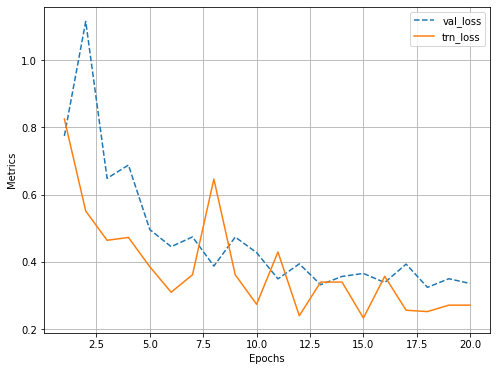

In [16]:
log.plot_epochs(['trn_loss','val_loss'])

In [17]:
im, mask = next(iter(val_dl))

_mask = model(im)


Fetch the channel that has the highest probability:

In [18]:
_, _mask = torch.max(_mask, dim=1)

Show the original and predicted images:

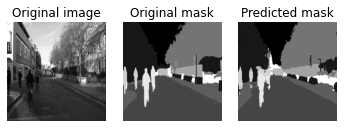

In [19]:
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], \

  mask.permute(1,2,0).detach().cpu()[:,:,0], \

  _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=3, \

  titles=['Original image','Original mask', \

  'Predicted mask'])